BEFORE RUNNING THIS NOTEBOOK:

The tiles for training the first model can be downloaded from github in two zip files ('relabeled_tiles_pt1/2'), then unzipped and saved into a folder in the notebook directory called 'Relabeled_tiles'. Alternatively, if the notebook finds this folder empty, it will automatically download the tiles from Google Cloud (but it takes a few minutes).




In [41]:
# General libraries
from google.cloud import storage
import math
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from geopy.distance import geodesic
import google.datalab.bigquery as bq

# Plotting and Data preprocessing libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import seaborn as sns
from os.path import isfile, join
import cv2


# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Image preprocessing libraries
import skimage.filters as skif
from skimage.io import imread
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
from skimage.filters import median
from skimage.filters import gaussian


%matplotlib inline

In [2]:
# Create needed folders and load Google credentials for GCP
if not os.path.exists('divided_documents'):
    os.makedirs('divided_documents')
if not os.path.exists('Relabeled_tiles'):
    os.makedirs('Relabeled_tiles')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="elegant-weaver-287722-1c18abef2983.json"

In [3]:
# Check for needed json file and download from GCP if necessary
if not os.path.isfile('shipsnet.json'):
    print('fetching json...')
    storage_client = storage.Client("elegant-weaver-287722")
    # Create a bucket object
    bucket = storage_client.get_bucket('207_ais_project')
    blob = bucket.blob('json/shipsnet.json')
    filename = 'shipsnet.json'
    blob.download_to_filename(filename)
    print('done')

# IMAGE SPLIT FUNCTION

In [4]:
def cut_tiles(raw_image, dim):
    """ Split the image into multiple square tiles by a specified number of a pixels while calculating the latitude and longitude of each new square image. 
    # param raw_image: an image file to be split
    # dim: an integer specifying the dimension of the smaller square images to split the raw_image into
    # return: Dictionary of latitude and longitude coordinates of each new split image
    """
  # adjustments for image irregularity -----manipulate at your peril----
    xspan_adj = .0335
    yspan_adj = .03
    #---------------------------------------------------------------------

    # raw image corner coordinates

    coords_1 = (37.769519, -122.358280)
    coords_2 = (37.769519, -122.30600)
    coords_3 = (37.769519, -122.358280)
    coords_4 = (37.735514, -122.358280)

    width = geodesic(coords_1, coords_2).m
    height = geodesic(coords_3, coords_4).m
    print(width)
    print(height)


    #kaggle scene
    img = raw_image


    width_pixel = width/img.shape[0]
    height_pixel = height/img.shape[1] 

    #EMPTY FOLDER
    import glob
    clear = 1

    if clear == 1:
        tile_files = 'divided_documents'
        filelist = [f for f in os.listdir(tile_files) if f.endswith(".png") ]
        for f in filelist:
            os.remove(os.path.join(tile_files, f))


    # Dim is the dimension of the images we want to split into
    dim = 80
    r_earth = 6371000.0 #radius of earth estimate in meters
    latitude, longitude = coords_1 #start from top left as the image is read right-down
    dx, dy = 0, 0
    lat_longs = {}


    for r in range(0,img.shape[0],dim):#latitude
        dy = height_pixel*r
        new_latitude = latitude - (dy / r_earth) * (180 / math.pi)
        for c in range(0,img.shape[1],dim):#longitude
            dx = width_pixel*c
            new_longitude = longitude + (dx / r_earth) * (180 /math.pi) / math.cos(latitude * math.pi/180)
            # uncomment the following line to save the split images
            cv2.imwrite(f"divided_documents/img{r}_{c}.png",img[r:r+dim, c:c+dim,:])
            # start from top left and go right and downward
            lat_longs[f"img{r}_{c}.png"] = (new_latitude, new_longitude)

  # os.getcwd()
  #images here: https://drive.google.com/drive/folders/1MZmtRpCeR0EtaI9eJTbfCLi8capvSUsQ?usp=sharing
    return(lat_longs)

raw_image = cv2.imread('planet.png')
dim = 80

#run function
lat_longs = cut_tiles(raw_image, dim)



4606.215091234872
3774.276115468922


In [5]:
def download_tiles():
    """ Download the split image tiles from Google Cloud
    # return: None
    """
    print('fecthing tiles...')
    storage_client = storage.Client("elegant-weaver-287722")
    # Create a bucket object
    bucket = storage_client.get_bucket('relabeled_tiles')
    
    prefix = 'Relabeled_tiles/'
    blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
    for blob in blobs:
        filename = blob.name
        blob.download_to_filename(filename)
    print('done')

# SHIP/NO SHIP MODEL

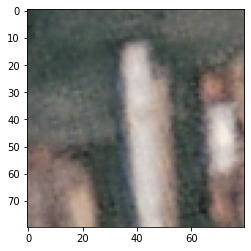

In [6]:
#Get training tiles for model

# Check whether the folder of training tile folder exists and is populated
check_file = 'Relabeled_tiles/0__20150718_184300_090b__-122.35324421973536_37.772113980272394.png' 
isFile = os.path.isfile(check_file) 

#Download files if needed (this may take a while)
if isFile == False:
    download_tiles()

relabeled_tile_path = 'Relabeled_tiles'
files = [f for f in listdir(relabeled_tile_path) if isfile(join(relabeled_tile_path, f))]
x = []
y = []
for file in files:
    label = file.split('_')[0] 
    y.append(label)
    xtile = plt.imread(relabeled_tile_path + '/' + str(file))
    x.append(xtile)

x = np.array(x)
y = np.array(y)
plt.imshow(x[1])
plt.show()
x_flat = x.reshape(len(x),-1)
train_data, val_data, train_y, val_y = train_test_split(x_flat, y, test_size=0.2, random_state=43)
  

In [7]:
print(f'Number of ship images: {np.count_nonzero(y == "1")}')
print(f'Number of non-ship images: {np.count_nonzero(y == "0")}')

Number of ship images: 1899
Number of non-ship images: 2101


In [8]:
def train_test_data(images, labels):
    """ Combine the flatten and train test split steps into one line
    # param images: Numpy arrays of images to be split
    # param labels: Numpy array of the image labels
    # return: X_train, X_test, y_train, y_test data
    """
    x_flat = images.reshape(len(images),-1)
    X_train, X_test, y_train, y_test = train_test_split(x_flat, y, test_size=0.2, random_state=43)
    return X_train, X_test, y_train, y_test

In [9]:
# Convert the read in image data into data to be modeled
X_train, X_test, y_train, y_test = train_test_data(x, y)

In [10]:
print(f'TRAINING SET - Number of ship images: {list(y_train).count("1")}, Number of non-ship images: {list(y_train).count("0")}')
print(f'TEST SET - Number of images {X_test.shape[0]}')

TRAINING SET - Number of ship images: 1525, Number of non-ship images: 1675
TEST SET - Number of images 800


In [11]:
# Try a variety of models and start optimizing the one with the best baseline accuracy
models = [
          ('LogReg', LogisticRegression(solver='liblinear', random_state=43)), 
          ('RF', RandomForestClassifier(random_state=43)),
          ('KNN', KNeighborsClassifier()),
          ('SVC', SVC()), 
          ('GNB', GaussianNB()),
        ]

for name, model in models:
    clf = model.fit(X_train,y_train)
    pre=clf.predict(X_test)
    print(f"{name} Accuracy:{accuracy_score(y_test,pre)}")



LogReg Accuracy:0.73875
RF Accuracy:0.9
KNN Accuracy:0.765
SVC Accuracy:0.84875
GNB Accuracy:0.59125


## Data preprocessing + Random Forest

Random Forest gave the best results so we can now focus on optimizing it with different image preprocessing techniques.

In [12]:
def test_changes(X_train, y_train, X_test):
    """ Tests the random forest classifier on differents data sets and prints the accuracy
    # param X_train: X_train dataset after splitting the data
    # param y_train: y_train dataset after splitting the data
    # param X_test:X_test dataset after splitting the data
    # return: None
    """
    rf=RandomForestClassifier(random_state=43)
    rf.fit(X_train,y_train)
    pre=rf.predict(X_test)
    print ("Accuracy:",accuracy_score(y_test,pre))

In [13]:
# Raw no processing
X_train, X_test, y_train, y_test = train_test_data(x, y)
test_changes(X_train, y_train, X_test)

Accuracy: 0.9


Accuracy: 0.8925


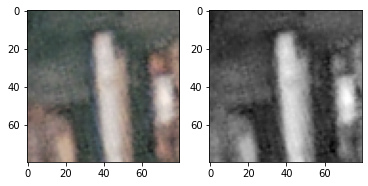

In [14]:
# Trying with Grayscale filter
gray = rgb2gray(x)
X_train, X_test, y_train, y_test = train_test_data(gray, y)
test_changes(X_train, y_train, X_test)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x[1])
ax[1].imshow(gray[1], cmap="gray")

Accuracy: 0.90375


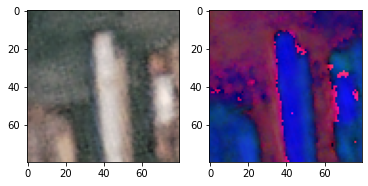

In [15]:
# Trying with HSV filter
hsv = rgb2hsv(x)
X_train, X_test, y_train, y_test = train_test_data(hsv, y)
test_changes(X_train, y_train, X_test)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x[1])
ax[1].imshow(hsv[1])

Accuracy: 0.90125


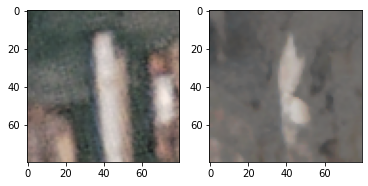

In [16]:
# median filter
median = median(x)
X_train, X_test, y_train, y_test = train_test_data(median, y)
test_changes(X_train, y_train, X_test)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x[1])
ax[1].imshow(median[1])

Accuracy: 0.8925


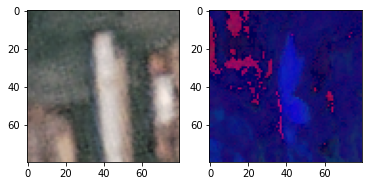

In [17]:
# median + hsv filters
median_hsv = rgb2hsv(median)
X_train, X_test, y_train, y_test = train_test_data(median_hsv, y)
test_changes(X_train, y_train, X_test)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x[1])
ax[1].imshow(median_hsv[1])

Accuracy: 0.935


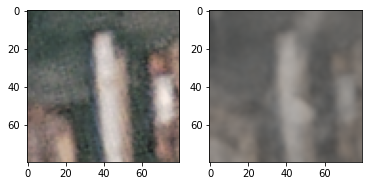

In [18]:
# Gaussian filter
gaussian = gaussian(x)
X_train, X_test, y_train, y_test = train_test_data(gaussian, y)
test_changes(X_train, y_train, X_test)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x[1])
ax[1].imshow(gaussian[1])

Accuracy: 0.9575


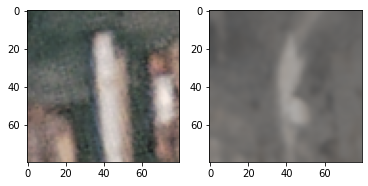

In [19]:
# Gaussian + median filter
from skimage.filters import gaussian 
gaussian_med = gaussian(median)
X_train, X_test, y_train, y_test = train_test_data(gaussian_med, y)
test_changes(X_train, y_train, X_test)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x[1])
ax[1].imshow(gaussian_med[1])

Accuracy: 0.93375


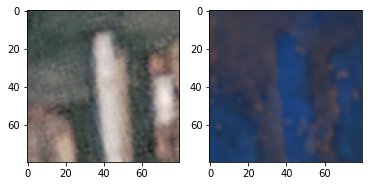

In [20]:
# Gaussian + HSV 
gaussian_hsv = gaussian(hsv)
X_train, X_test, y_train, y_test = train_test_data(gaussian_hsv, y)
test_changes(X_train, y_train, X_test)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x[1])
ax[1].imshow(gaussian_hsv[1])

## Optimize the Random Forest with the Image Filters

Our best result is with the Guassian + Median filter so we can run Grid Search on the data with these parameters

In [21]:
# Run a grid search optimizng the two parameters. We cannot add too many parameters due to the increase in run time
param_grid = {'max_depth': [10, 50, 100, None],
              'n_estimators': [50, 100, 500, 1000]
             }

grid = GridSearchCV(RandomForestClassifier(random_state=43),param_grid,refit = True, verbose=2)

In [22]:
# Get data from the Gaussian + median filtered data
X_train, X_test, y_train, y_test = train_test_data(gaussian_med, y)

In [23]:
# grid.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................max_depth=10, n_estimators=50; total time=   6.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   6.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   6.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   6.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   6.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=  12.5s
[CV] END .....................max_depth=10, n_estimators=100; total time=  12.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=  12.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=  12.5s
[CV] END .....................max_depth=10, n_estimators=100; total time=  12.6s
[CV] END .....................max_depth=10, n_estimators=500; total time= 1.0min
[CV] END .....................max_depth=10, n_es

GridSearchCV(estimator=RandomForestClassifier(random_state=43),
             param_grid={'max_depth': [10, 50, 100, None],
                         'n_estimators': [50, 100, 500, 1000]},
             verbose=2)

In [24]:
# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'max_depth': 50, 'n_estimators': 1000}
RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=43)


In [25]:
# Using the preprocessed data + optimzied RF model
X_train, X_test, y_train, y_test = train_test_data(gaussian_med, y)
# Train test split the original data to be used for plotting later
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_data(x, y)
rfc = RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=43)
rfc.fit(X_train,y_train)
pre=rfc.predict(X_test)
print(f"Accuracy:{accuracy_score(y_test,pre)}")

Accuracy:0.95375


We see that even with the optimized hyperparameters, the accuracy did not improve.

## PCA

We can now try to see if just reducing the dimensionality improves performance.

In [26]:
# Scale the data before PCA to ensure best results
scaler = StandardScaler()
scaled_x = scaler.fit_transform(X_train)
scaled_test = scaler.transform(X_test)

In [27]:
variances = [0.99, 0.95, 0.9, 0.85]

dataframe = []

# Run PCA with different variance thresholds
for var in variances:
    t0 = time.time()
    pca = PCA(var)
    x_new = pca.fit_transform(scaled_x)
    x_test_new = pca.transform(scaled_test)
    rfcc = RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=43)
    rfcc.fit(x_new,y_train)
    pred=rfcc.predict(x_test_new)
    accuracy = accuracy_score(y_test,pred)
    t1 = time.time()
    dataframe.append([var, pca.n_components_, t1-t0, accuracy])

In [28]:
df = pd.DataFrame(dataframe, columns=['Variance Retained', 'Number of Components', 'Time (seconds)', 'Accuracy'])
df

,Variance Retained,Number of Components,Time (seconds),Accuracy
0,0.99,149,32.172719,0.97000
1,0.95,32,20.256506,0.96375
2,0.90,10,18.123618,0.93875
3,0.85,4,17.214985,0.81625


By keeping 99% of the variance and reducing the feature space from 19200 to 149 components we can boost the accuracy to nearly 97%.

In [29]:
# Run our final preprocessing steps to get our final model
pca = PCA(0.99)
x_new = pca.fit_transform(scaled_x)
x_test_new = pca.transform(scaled_test)
rfcc = RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=43)
rfcc.fit(x_new,y_train)
pred=rfcc.predict(x_test_new)

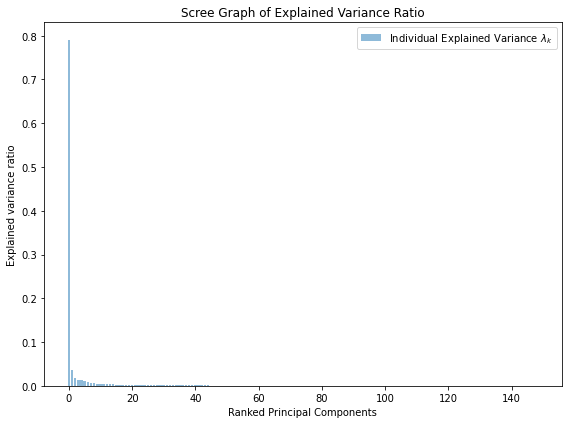

In [30]:
# Plot the explained variance ratios
X_std = x_new
X_mean = np.mean(X_std, axis=0)

X_cov = (X_std - X_mean).T.dot((X_std - X_mean)) / (X_std.shape[0]-1)

eigenvals, eigenvecs = np.linalg.eig(X_cov)

lam_sum = sum(eigenvals)
explained_variance = [(lam_k/lam_sum) for lam_k in sorted(eigenvals, reverse=True)]


plt.figure(figsize=(8, 6))

plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center',
        label='Individual Explained Variance $\lambda_{k}$')

plt.ylabel('Explained variance ratio')
plt.xlabel('Ranked Principal Components')
plt.title("Scree Graph of Explained Variance Ratio")

plt.legend(loc='best')
plt.tight_layout()

[Text(30.5, 0.5, 'Predicted Label'), Text(0.5, 12.5, 'True Label')]

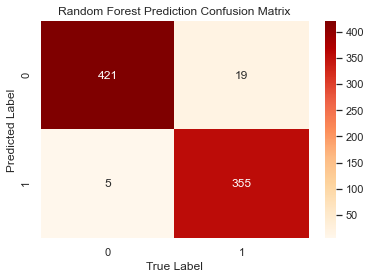

In [31]:
# Plot a confusion matrix to evaluate results
C2=confusion_matrix(list(pred), list(y_test), sample_weight=None)

sns.set()
f,ax=plt.subplots()

sns.heatmap(C2,annot=True,ax=ax,cmap="OrRd", fmt='.20g') #heatmap
ax.set_title('Random Forest Prediction Confusion Matrix') #title
ax.set(ylabel="Predicted Label", xlabel="True Label")

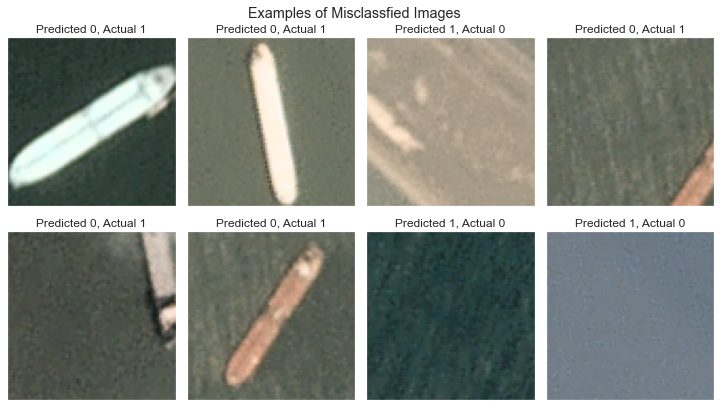

In [32]:
# Print some misclassified images
indices = [i for i, x in enumerate(y_test != pred) if x]

fig, ax = plt.subplots(2, 4,figsize=(10,8))
i = 10
for row in ax:
    for col in row:
        col.imshow(X_test_orig[indices[i]].reshape(80, 80, 3))
        col.grid(False)
        col.set_title(f'Predicted {pred[indices[i]]}, Actual {y_test[indices[i]]}')
        col.set_xticklabels([])
        col.set_yticklabels([])
        i+=1

fig.suptitle("Examples of Misclassfied Images")
fig.subplots_adjust(hspace=0, wspace=0)
fig.tight_layout(rect=[0, 0.2, 1.2, 0.95])
fig.subplots_adjust(top=1, right=1)
plt.show()

# SHIP/NO SHIP MODEL WITH LIVE DATA

In [33]:
# Retrain the random forest model on raw sample data for comparison
train_data, val_data, train_y, val_y = train_test_data(x, y)
rfc_l = RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=43)
rfc_l.fit(train_data,train_y)

RandomForestClassifier(max_depth=50, n_estimators=1000, random_state=43)

In [34]:
#Collect full image tiles (not partials on the border)
 
mypath2 = 'divided_documents'
# mypath2 = relabeled_tile_path
files2 = [f for f in listdir(mypath2) if isfile(join(mypath2, f))]
search_tiles = []
search_tile_labels = []

for file in files2:
    img2 = plt.imread(mypath2 + '/' + str(file))

    if img2.shape == (80, 80, 3):
        search_tiles.append(img2)
        search_tile_labels.append(str(file))
search_tiles = np.array(search_tiles)
# # plt.imshow(x2[3])
# # plt.show()
search_tiles_flat = search_tiles.reshape(len(search_tiles),-1)


In [35]:
#Manually create ship/no ship list to check accuracy of live model

#manually generated index of actual ship-containing tiles for Kaggle scene
ship_list = ['img400_1600.png', 'img400_1680.png', 'img400_1920.png','img480_1600.png',
             'img480_1920.png', 'img480_2160.png', 'img720_880.png', 'img880_1680.png',
             'img880_1760.png', 'img800_2000.png', 'img880_2000.png', 'img960_1680.png',
             'img960_1760.png', 'img1120_1840.png', 'img1200_1840.png','img1200_2160.png',
             'img1200_2480.png', 'img1280_2480.png','img1600_2560.png', 'img1680_2560.png']

real_y = []
for i in range(len(search_tile_labels)):
    if search_tile_labels[i] in ship_list:
        real_y.append('1')
    else: real_y.append('0')
# print(real_y)

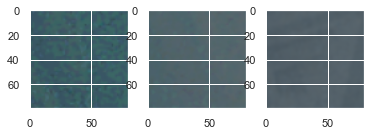

In [42]:
#Convert search tiles to gaussian + median to match our most successful preprocessing (model rfc)
# median filter
median_l = skif.median(search_tiles)
# Gaussian + median filter
gaussian_med_l = skif.gaussian(search_tiles)
gaussian_med_l_flat = search_tiles.reshape(len(gaussian_med_l),-1)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(search_tiles[20])
ax[1].imshow(median_l[20])
ax[2].imshow(gaussian_med_l[20])

In [46]:
pred = rfc.predict(gaussian_med_l_flat)
probs = rfc.predict_proba(gaussian_med_l_flat)
print(f"Accuracy:{accuracy_score(real_y, pred)}")
len(pred[pred != '0'])
hit_index = []
for i in range(len(pred)):
  if pred[i] == '1':
      # print(i)
      hit_index.append(i)
print(len(hit_index))
print(hit_index)
cc= sklearn.metrics.confusion_matrix(list(pred), list(real_y), sample_weight=None)
print("Found ships (true pos): ", cc[1][1])
print("Missed ships (false neg): ", cc[0][1])

Accuracy:0.9939393939393939
1
[53]


NameError: name 'sklearn' is not defined

In [47]:
pred = rfc_l.predict(search_tiles_flat)
probs = rfc_l.predict_proba(search_tiles_flat)
print(f"Accuracy:{accuracy_score(real_y, pred)}")
len(pred[pred != '0'])
hit_index = []
for i in range(len(pred)):
  if pred[i] == '1':
      # print(i)
      hit_index.append(i)
print(len(hit_index))
print(hit_index)
cc=sklearn.metrics.confusion_matrix(list(pred), list(real_y), sample_weight=None)
print("Found ships (true pos): ", cc[1][1])
print("Missed ships (false neg): ", cc[0][1])

Accuracy:0.9393939393939394
10
[2, 5, 11, 14, 25, 28, 32, 53, 126, 151]


NameError: name 'sklearn' is not defined

10


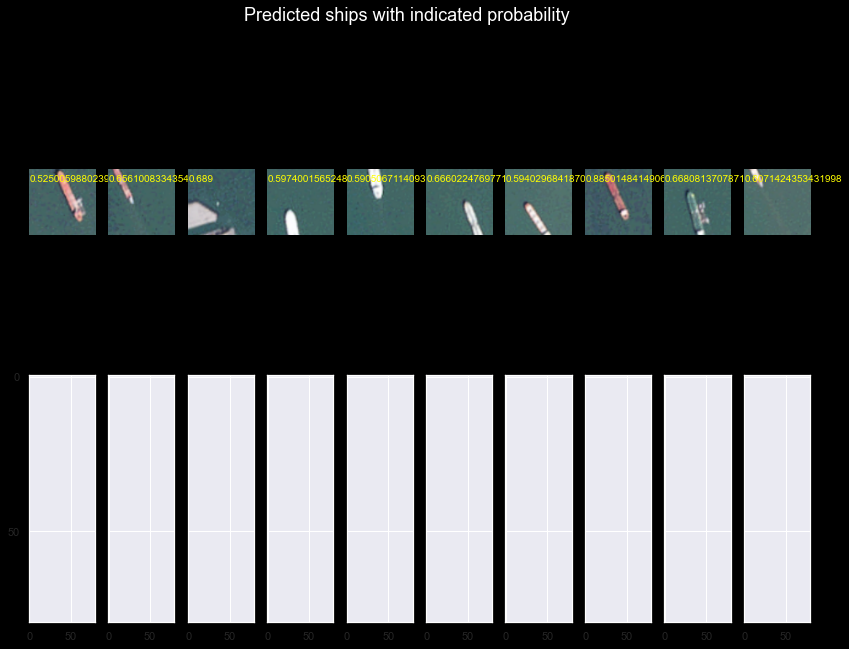

In [48]:
#Create list of tiles based on ships found (hit_index)
ship_tiles = []
for i in hit_index:
  ship_tiles.append(search_tile_labels[i])


#  Show predicted ship tiles with probability
print(len(hit_index))
fig, ax = plt.subplots(nrows = 1 + int(len(hit_index)/10), ncols = 10, sharex=True, sharey=True, figsize = (14, 10))
ax = ax.flatten()
for i in range(len(hit_index)):    
    ax[i].imshow(search_tiles[hit_index[i]])
    ax[i].text(0,15,max(probs[hit_index[i]]), color = 'yellow' )
    ax[i].axis('off')
    ax[i].set(facecolor = 'black')
fig.suptitle("Predicted ships with indicated probability", fontsize=18, c = 'white')
fig.set_facecolor('black')
plt.show()

# AIS QUERY

In [49]:
#(function) build query for AIS

# 2016-08-31T00:00:00.000Z  to 2016-09-01T00:00:00.000Z

####Set ROUND value of RLAT, RLON to control coordinate precision
def make_query(vessel_num, ship_tiles, lat_longs):
  
  vessel_image = ship_tiles[vessel_num]

  # set parameters
  v_lat_long = lat_longs[vessel_image]
  lat = v_lat_long[0]
  lon = v_lat_long[1]

  #set minimum vessel length
  min_len = 200


  #set lat and lon tolerance (ideal range .005)
  lat_range = .005
  lon_range = .005
  #set image date (month, day, year)
  date = (3, 26, 2020)
  month, day, year = date
  #set time range if timestamp unknown (+/-; 0 for exact)
  day_range = 1
  month_range = 0
  year_range = 0

  print(v_lat_long)

  #build query
#   a = 'SELECT DISTINCT VesselName, Callsign, VesselType, Month, Day, Year, Hour, Heading, Status, Length, RLAT, RLON, \
#   FROM (SELECT *, FROM (SELECT *, EXTRACT(HOUR FROM BaseDateTime) AS hour, EXTRACT(DAY FROM BaseDateTime) AS day, EXTRACT(MONTH FROM BaseDateTime) AS month, EXTRACT(YEAR FROM BaseDateTime) AS year, \
#   ROUND(LAT, 3) AS RLAT, ROUND(LON, 3) AS RLON, \
#   FROM `elegant-weaver-287722.207Final.COMPOSITE_AIS`) WHERE day >= '     

  a = 'SELECT DISTINCT VesselName, Callsign, VesselType, Month, Day, Year, Hour, Heading, Status, Length, RLAT, RLON, \
  FROM (SELECT *, FROM (SELECT *, EXTRACT(HOUR FROM BaseDateTime) AS hour, EXTRACT(DAY FROM BaseDateTime) AS day, EXTRACT(MONTH FROM BaseDateTime) AS month, EXTRACT(YEAR FROM BaseDateTime) AS year, \
  ROUND(LAT, 3) AS RLAT, ROUND(LON, 3) AS RLON, \
  FROM `elegant-weaver-287722.207Final.3-26-2020`) WHERE day >= '   


  day_min = str(day - day_range)
  b = ' AND day <=  '
  day_max = str(day + day_range)
  c = ' AND month >= '
  month_min = str(month - month_range)
  d = ' AND month <= '
  month_max = str(month + month_range)
  e = ' AND year >= '
  year_min = str(year - year_range)
  f = ' AND year <= '
  year_max = str(year + year_range)
  g = ' AND LAT > '
  lat_min = str(lat - lat_range)
  h = ' AND LAT < '
  lat_max = str(lat + lat_range)
  i = ' AND LON > '
  lon_min = str(lon - lon_range)
  j = ' AND LON < '
  lon_max = str(lon + lon_range)
  k = ' AND Length > '
  min_len = str(min_len)
  l = ') LIMIT '
  limit = str(100000)

  query = a + day_min + b + day_max + c + month_min + d + month_max + e + year_min + f + year_max + g + lat_min + h + lat_max + i + lon_min + j + lon_max + k + min_len + l + limit
  print(query)
  return(query)

# KNN SHIP IDENTIFICATION


In [50]:

def knn_id(ais_df, lat_longs, ship_tiles, vessel_num):
  if ais.empty:
    return(['UNCONFIRMED VESSEL'])
  
  #KNN Setup
  feature_set = ['RLAT', 'RLON']
  train_data = []
  for i in range (len(ais[['RLAT']])):
    features = []
    features.append(ais.at[i, feature_set[0]])
    features.append(ais.at[i, feature_set[1]])
    train_data.append(features)

  train_labels = []
  for i in range (len(ais[['VesselName']])):
    train_labels.append(ais.at[i,'VesselName'])

  dev_data = []
  inner_data = []
  inner_data.append(lat_longs[ship_tiles[vessel_num]][0])
  inner_data.append(lat_longs[ship_tiles[vessel_num]][1])
  dev_data.append(inner_data)

  #KNN
  knn = KNeighborsClassifier(n_neighbors = 5, p = 2, metric='minkowski')
  knn.fit(train_data, train_labels)
  y_pred = knn.predict(dev_data)
  # error = (dev_labels != y_pred).sum()/len(y_pred)
  return(y_pred)



In [51]:
# query
# https://marinecadastre.gov/ais/
# https://marinecadastre.gov/img/data-dictionary.jpg


vessel_num = 0
vessel_names = []

pd.set_option('display.max_rows', 1000000)

# general = 'SELECT * FROM `elegant-weaver-287722.207Final.COMPOSITE_AIS` LIMIT 10'
# query = general
for i in range(len(ship_tiles)):
# for i in range(2):
  vessel_num = i
  query = make_query(vessel_num, ship_tiles, lat_longs)

  df = bq.Query(query).execute().result().to_dataframe()
  try:
    ais = df[df['VesselName'].notnull()].reset_index()
  # print(ais['VesselName'].unique())
  # print(len(ais['VesselName']))
#   print(ais[['VesselName']])
  except KeyError:
    ais = pd.DataFrame()
  # ais
  try:
    name = knn_id(ais, lat_longs, ship_tiles, vessel_num)[0]
  except ValueError:
    name = 'UNCONFIRMED VESSEL'
  print(name)
  vessel_names.append(name)

(37.769519, -122.34799622395239)
SELECT DISTINCT VesselName, Callsign, VesselType, Month, Day, Year, Hour, Heading, Status, Length, RLAT, RLON,   FROM (SELECT *, FROM (SELECT *, EXTRACT(HOUR FROM BaseDateTime) AS hour, EXTRACT(DAY FROM BaseDateTime) AS day, EXTRACT(MONTH FROM BaseDateTime) AS month, EXTRACT(YEAR FROM BaseDateTime) AS year,   ROUND(LAT, 3) AS RLAT, ROUND(LON, 3) AS RLON,   FROM `elegant-weaver-287722.207Final.3-26-2020`) WHERE day >= 25 AND day <=  27 AND month >= 3 AND month <= 3 AND year >= 2020 AND year <= 2020 AND LAT > 37.764519 AND LAT < 37.774519000000005 AND LON > -122.35299622395239 AND LON < -122.3429962239524 AND Length > 200) LIMIT 100000
HON HENRY JACKMAN
(37.769519, -122.3377124479048)
SELECT DISTINCT VesselName, Callsign, VesselType, Month, Day, Year, Hour, Heading, Status, Length, RLAT, RLON,   FROM (SELECT *, FROM (SELECT *, EXTRACT(HOUR FROM BaseDateTime) AS hour, EXTRACT(DAY FROM BaseDateTime) AS day, EXTRACT(MONTH FROM BaseDateTime) AS month, EXTRACT

# DISPLAY

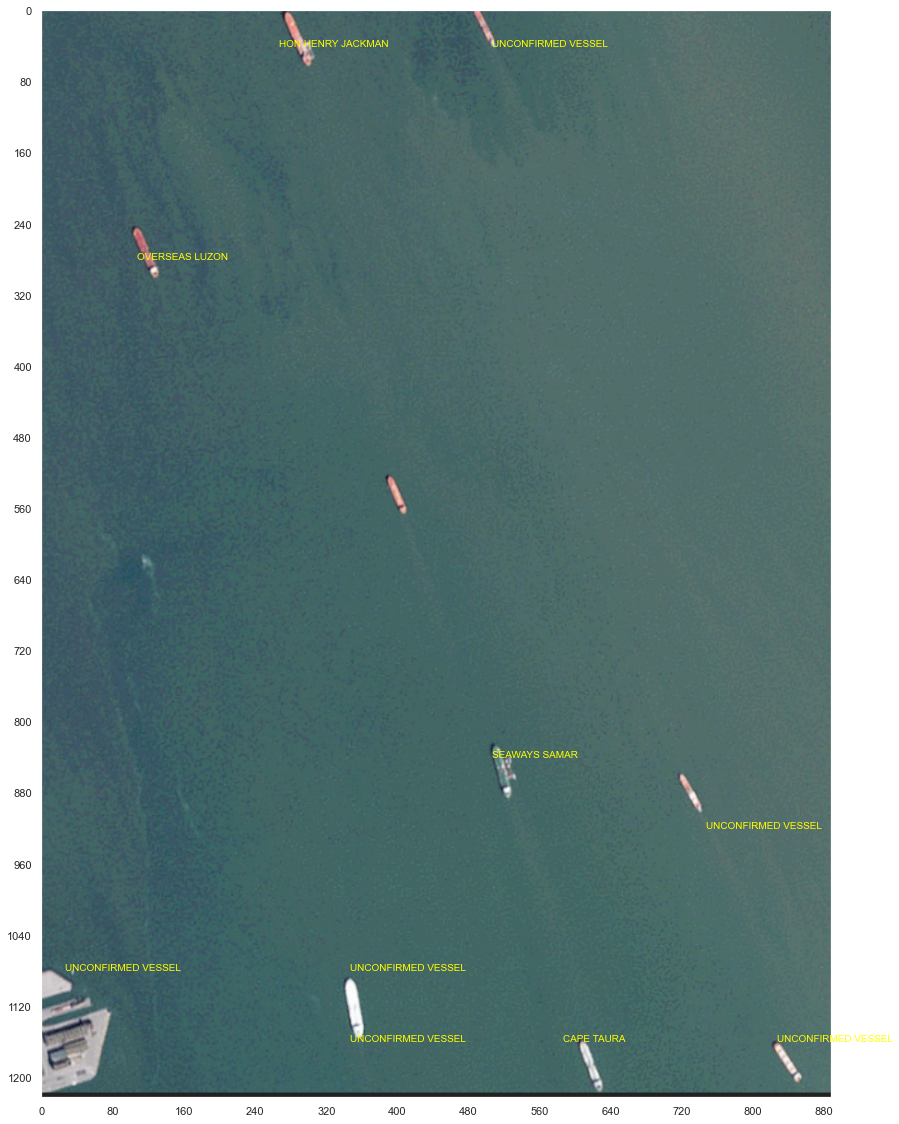

In [52]:
fig, ax = plt.subplots(figsize=(20,20))


for tile in range(len(ship_tiles)):
  y_num = int(ship_tiles[tile][3:].split('_')[0])
  x_num = int(ship_tiles[tile][3:].split('_')[1].split('.')[0])
  # print(ship_tiles[tile], x_num, y_num)
  ax.text(x_num + dim/3, y_num + dim/2,vessel_names[tile], color = 'yellow' )

grid_on = 0
ax.set_xticks(range(0, raw_image.shape[1], 80)) 
ax.set_yticks(range(0, raw_image.shape[0], 80)) 
if grid_on == 0:
    ax.grid(False) 

ax.imshow(plt.imread('planet.png'))
plt.show()

#save output
fig.savefig('output.png')